In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
filename = 'AllPublicnew.sdf'
filepath = f'{filename}'

download_url = f'https://zenodo.org/records/3540701/files/{filename}'

if not os.path.exists(filepath):
    !wget {download_url} -O {filepath}
else:
    print("File already exists:", filepath)

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
def in_google_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False


In [4]:
!pip install jaqpotpy
!pip install rdkit
!pip install torch-geometric

# !pip install jaqpotpy
# !pip install rdkit

!pip install scikit-learn
!pip install torch

In [28]:
seed = 42

random.seed(seed)
np.random.seed(seed)

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = torch.cuda.is_available()

torch.manual_seed(seed)

if cuda:
    print(f"Device: \n- {torch.cuda.get_device_name()}")
    torch.cuda.manual_seed(seed)
else:
    print(f"Device: {'CPU'}")


Device: 
- NVIDIA GeForce GTX 1050 Ti with Max-Q Design


In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem
from pathlib import Path

import sys

if '..' not in sys.path:
    sys.path.append('..')
    
from utils.utils import class_balanced_random_split

working_dir = Path.cwd()
filename = 'AllPublicnew.sdf'


if in_google_colab():
    data_dir = working_dir
else:
    data_dir = working_dir.parent/'data'/'ready_biodegradability'
    
   
    
dataset_filepath = data_dir/filename


X, y = [], []
sdf_supplier = Chem.SDMolSupplier(str(dataset_filepath))

for mol in sdf_supplier:
    if mol is not None:
        smiles = mol.GetProp('SMILES')
        # smiles = Chem.MolToSmiles(mol)
        ready_biodegradability = int(mol.GetProp('ReadyBiodegradability'))

        X.append(smiles)
        y.append(ready_biodegradability)

In [6]:
import numpy as np

seed = 42

n_all = len(y)
print(f"Whole Dataset ({100*(np.array(y)==1).sum()/n_all:.1f}% positive):")
print(f"- Positive Samples: {(np.array(y)==1).sum():,}")
print(f"- Negative Samples: {(np.array(y)==0).sum():,}")
print('\n')

# TODO: Need oversampling on train data AFTER spliting on train-validtaion as well

# Create test split
X_train_val, X_test, y_train_val, y_test = class_balanced_random_split(X, y, seed=seed)

# Create train and validation splits
X_train, X_val, y_train, y_val = class_balanced_random_split(X_train_val, y_train_val, seed=seed)


# n_train = len(y_train)
# print(f"Train Split ({100*(np.array(y_train)==1).sum()/n_train:.1f}% positive):")
# print(f"- Positive Train Samples: {(np.array(y_train)==1).sum():,}")
# print(f"- Negative Train Samples: {(np.array(y_train)==0).sum():,}")
# print('\n')

# n_val = len(y_val)
# print(f"Validation Split ({100*(np.array(y_val)==1).sum()/n_val:.1f}% positive):")
# print(f"- Positive Validation Samples: {(np.array(y_val)==1).sum():,}")
# print(f"- Negative Validation Samples: {(np.array(y_val)==0).sum():,}")
# print('\n')



# n_test = len(y_test)
# print(f"Test Split ({100*(np.array(y_test)==1).sum()/n_test:.1f}% positive):")
# print(f"- Positive Test Samples: {(np.array(y_test)==1).sum():,}")
# print(f"- Negative Test Samples: {(np.array(y_test)==0).sum():,}")
# print('\n')

Whole Dataset (35.5% positive):
- Positive Samples: 1,133
- Negative Samples: 2,059




### Structural data of the dataset for graph node feature creation

In [7]:
from rdkit import Chem
Symb , Hs , Impv , Fc , Hb , ExpV , Deg = set() , set() , set() , set() , set() , set() , set()
bond_type , conj = set() , set()

for smile in X:
    for atom in Chem.MolFromSmiles(smile).GetAtoms():
#         print('ELA')
        Symb.add(atom.GetSymbol())
#         print(atom.GetSymbol())
        Hs.add(atom.GetTotalNumHs())
#         print(atom.GetTotalNumHs())
        Impv.add(atom.GetImplicitValence())
#         print(atom.GetImplicitValence())
        Fc.add(atom.GetFormalCharge())
#         print(atom.GetFormalCharge())
        Hb.add(atom.GetHybridization())
#         print(atom.GetHybridization())
        ExpV.add(atom.GetExplicitValence())
#         print(atom.GetExplicitValence())
        Deg.add(atom.GetDegree())
#         print(atom.GetDegree())
        
    for bond in Chem.MolFromSmiles(smile).GetBonds():
        bond_type.add(bond.GetBondType())
        conj.add(bond.GetIsConjugated())
        
print('Symb: ', Symb)
print('Hs: ', Hs)
print('Impv: ', Impv)
print('Fc: ', Fc)
print('Hb: ', Hb)
print('ExpV: ', ExpV)
print('Deg: ', Deg)



print("Bond Types:", bond_type)
print("Is_Conjugated:", conj)

Symb:  {'Br', 'I', 'B', 'F', 'S', 'Si', 'C', 'N', 'Cl', 'Cu', 'Bi', 'Sn', 'P', 'O'}
Hs:  {0, 1, 2, 3, 4}
Impv:  {0, 1, 2, 3, 4}
Fc:  {0, 1, -1}
Hb:  {rdkit.Chem.rdchem.HybridizationType.SP, rdkit.Chem.rdchem.HybridizationType.SP2, rdkit.Chem.rdchem.HybridizationType.SP3, rdkit.Chem.rdchem.HybridizationType.SP3D2}
ExpV:  {0, 1, 2, 3, 4, 5, 6}
Deg:  {0, 1, 2, 3, 4}
Bond Types: {rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.DOUBLE, rdkit.Chem.rdchem.BondType.TRIPLE, rdkit.Chem.rdchem.BondType.AROMATIC}
Is_Conjugated: {False, True}


### Create the graph datasets

In [8]:
from rdkit import Chem

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception(f'input{x} not in allowable set{allowable_set}')
    return list(map(lambda s: x == s , allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x==s, allowable_set))

Symbols = list(Symb)

Degree = list(Deg)
Hs_Atoms = list(Hs)
Implicit_Val = list(Impv)
Formal_Charge = list(Fc)
Explicit_Val = list(ExpV)
Hybridization = list(Hb)

def atom_feature(atom):
    return torch.tensor(one_of_k_encoding_unk(atom.GetSymbol(), Symbols) +
                        one_of_k_encoding(atom.GetTotalNumHs(), Hs_Atoms) +
                        one_of_k_encoding(atom.GetDegree(), Degree) +
                        one_of_k_encoding(atom.GetImplicitValence(), Implicit_Val) +
                        one_of_k_encoding(atom.GetFormalCharge(), Formal_Charge) +
                        one_of_k_encoding(atom.GetHybridization(), Hybridization) +
                        one_of_k_encoding(atom.GetExplicitValence(), Explicit_Val) +
                        [atom.GetIsAromatic()], dtype=torch.int16)

In [9]:
from torch_geometric.data import Data

def nodes_and_adjacency(smile,y):

    mol = Chem.MolFromSmiles(smile)
    # Create node Features
    feats = []
    attr = []
    for atom in mol.GetAtoms():
        feats.append(atom_feature(atom)) # Get the 5 feats in a single atom of a mol
    mol_node_features = torch.stack(feats).float() # Stack them in an array [num_nodes x atom_features]

    # Create Adjacency Matrix
    ix1, ix2 = [], []

    for bond in mol.GetBonds():

        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        ix1 += [start, end]
        ix2 += [end, start]

    adj_norm = torch.asarray([ix1, ix2], dtype=torch.int64) # Needs to be in COO Format

    return Data(x=mol_node_features,
                edge_index=adj_norm,
                y=y)

In [10]:
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
import torch

class GraphDataset(Dataset):

    def __init__(self, smiles, y):
        super(GraphDataset,self).__init__()

        dataset_info = [nodes_and_adjacency(smile, y) for smile, y in (zip(smiles, y))]

        self.df = [info for info in dataset_info]

    def __getitem__(self,idx):
        return self.df[idx]

    def __len__(self):
        return len(self.df)

train_dataset = GraphDataset(X_train, y_train).df
val_dataset = GraphDataset(X_val, y_val).df
test_dataset = GraphDataset(X_test, y_test).df

### Create class of GCN Model

In [43]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GraphNorm
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool
import torch.nn.init as init




from typing import Optional, Iterable, Union


class GCN(nn.Module):

    def __init__(self,
                 input_dim: int,
                 hidden_dims: Iterable[int],
                 output_dim: Optional[int] = 1,
#                  final_activation: Optional[Union[str, None]] = None,
                 dropout: Union[float, Iterable[float]] = 0.5,
                 graph_norm: Optional[bool] = False,
                 *args,
                 **kwargs):
        
        super(GCN, self).__init__()
        
        # Input types check
        if not isinstance(input_dim, int):
            raise TypeError("input_dim must be of type int")
        
        if not isinstance(hidden_dims, Iterable):
            raise TypeError("hidden_dims must be an Iterable")
        if len(hidden_dims) == 0:
            raise ValueError("hidden_dims must not be empty")
        if not all(isinstance(hidden_dim, int) for hidden_dim in hidden_dims):
            raise TypeError("hidden_dims must only contain integers")
        
        if not isinstance(output_dim, int):
            raise TypeError("output_dim must be of type int")
            
#         if not (final_activation is None or isinstance(final_activation, str)):
#             raise TypeError("final_activation must be of type str or None")            
        
        if not (isinstance(dropout, float) or isinstance(dropout, Iterable)):
            raise TypeError("dropout must be either of type float or Iterable")
        if isinstance(dropout, float):
            if not 0 <= dropout <= 1:
                raise ValueError("dropout probability must be between 0 and 1")
        if isinstance(dropout, Iterable):
            for item in dropout:
                if not isinstance(value, float):
                    raise TypeError("dropout list must only contain floats")
                if not 0 <= value <= 1:
                    raise ValueError("Each element in the dropout list must be between 0 and 1")
            if len(dropout) != len(hidden_dims):
                raise ValueError("hidden_dims and dropout must be of same size")        
        
        if not isinstance(graph_norm, bool):
            raise TypeError("graph_norm must be of type bool")  
        
        
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
#         self.final_activation = final_activation
        self.dropout_probabilities = [dropout]*len(hidden_dims) if isinstance(dropout, float) else dropout
        self.graph_norm = graph_norm
        
        
        # Initialise GCNConv Layers
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(GCNConv(input_dim, hidden_dims[0]))
            
        for i in range(len(hidden_dims) - 1):
            hidden_layer = GCNConv(hidden_dims[i], hidden_dims[i+1])
            self.conv_layers.append(hidden_layer)
        
        
        # Initialise Graph Norm Layers
        if graph_norm:
            self.gn_layers = nn.ModuleList()
            for hidden_dim in hidden_dims:
                gn_layer = GraphNorm(hidden_dim)
                self.gn_layers.append(gn_layer)
            
        # Initialise Fully Connected Layer
        self.fc = nn.Linear(hidden_dims[-1], output_dim)
        
        # Apply Xavier initialization to fc
        init.xavier_uniform_(self.fc.weight)
        init.zeros_(self.fc.bias)
        
        self.fc1 = nn.Linear(hidden_dims[-1], 128)
        self.fc2 = nn.Linear(128, output_dim)
        
        
        
          
        
    def forward(self, x, edge_index, batch):

        for i, conv_layer in enumerate(self.conv_layers):
            x = conv_layer(x, edge_index)
            if self.graph_norm:
                x = self.gn_layers[i](x, batch)
#             x = F.relu(x)
            x = F.leaky_relu(x, 0.01)
            x = F.dropout(x, p=self.dropout_probabilities[i], training=self.training)
        
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        
#         x = self.fc1(x)
#         x = self.fc2(x)
        
        
#         if self.final_activation is None:
#             pass
#         if self.final_activation=='sigmoid':
#             x = F.sigmoid(x)
#         elif self.final_activation=='softmax':
#             x = F.softmax(x, dim=-1)
#         else:
#             raise NotImplementedError(f'"{self.final_activation}" is not supported as a final activation function.')
        
        return x
    


# gcn = GCN(input_dim=3, hidden_dims=[58], graph_norm=True)
# gcn

# class GAT(nn.Module):

#     def __init__(self, in_neurons, hid_layers, neurons, heads):
#         self.super(GAT).__init__()

#         self.hid_layers = hid_layers
#         self.layers = nn.ModuleList()
#         self.heads = heads
#         self.layers.append(GATConv(in_neurons, neurons, heads=self.heads))

#         for i in range(1, hid_layers):
#             gat_conv_layer = GATConv(neurons*self.heads, neurons, heads=self.heads)
#             self.layers.append(gat_conv_layer)

#         self.fc = nn.Linear(self.heads*neurons, 1)

#     def forward(self, x, edge_index, batch):

#         for layer in self.layers:
#             x = layer(x, edge_index)
#             x = F.relu(x)
#             x = F.dropout(x, p=0.2, training=self.training)

#         x = global_mean_pool(x, batch)
#         x = self.fc(x)
#         x = F.sigmoid(x)

#         return x

### Create Dataloaders

### Select loss function and optimizer

In [101]:
from tqdm import tqdm

# Train function
def train(epoch, n_epochs, loader, model, loss_fn, optimizer, device):
    
    running_loss = 0
    total_samples = 0
    tqdm_loader = tqdm(loader, desc=f'Epoch {epoch}/{n_epochs}')
    
    model.train()
    for _, data in enumerate(tqdm_loader):
        
        data = data.to(device)
        
        optimizer.zero_grad()

        outputs = model(x=data.x, edge_index=data.edge_index, batch=data.batch).squeeze(-1)
        
        epsilon = 0.2
        smoothed_labels = data.y.clone().float()
        smoothed_labels[data.y == 0] = (1 - epsilon) * data.y[data.y == 0] + epsilon / 2
        smoothed_labels[data.y == 1] = (1 - epsilon) * data.y[data.y == 1] + epsilon / 2
 
        loss = loss_fn(outputs.float(), smoothed_labels)
        
        

        running_loss += loss.item() * data.y.size(0)
        total_samples += data.y.size(0)
        
        loss.backward()
        optimizer.step()
        
        # Update tqdm description with additional information
        tqdm_loader.set_postfix(loss=running_loss/total_samples)
        
    avg_loss = running_loss / len(loader.dataset)
    
    tqdm_loader.set_postfix(loss=running_loss)
    tqdm_loader.close()
            
    return avg_loss


# train_loss = train(epoch, n_epochs, train_loader, model, loss_fn, optimizer, device)
    

In [85]:
import torch.nn.functional as F
import sklearn.metrics as metrics

def test(loader, model, loss_fn, device, decision_threshold=0.5):
    
    running_loss = 0
    total_samples = 0
    
    all_preds = []
    all_probs = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for _, data in enumerate(loader):
        
            data = data.to(device)
            
            outputs = model(x=data.x, edge_index=data.edge_index, batch=data.batch).squeeze(-1)
            
            probs = F.sigmoid(outputs)
            preds = (probs > decision_threshold).int()
            
            all_probs.extend(probs.tolist())
            all_preds.extend(preds.tolist())
            all_labels.extend(data.y.tolist())
            
            loss = loss_fn(outputs.float(), data.y.float())
            
            running_loss += loss.item() * data.y.size(0)
            total_samples += data.y.size(0)
        
        avg_loss = running_loss / len(loader.dataset)
    
    metrics_dict = compute_metrics(all_labels, all_preds)
    metrics_dict['roc_auc'] = metrics.roc_auc_score(all_labels, all_probs)
    conf_mat = metrics.confusion_matrix(all_labels, all_preds).ravel()
#     tn, fp, fn, tp = metrics.confusion_matrix(all_labels, all_preds).ravel()
#     conf_mat = {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}
    
        
    return avg_loss, metrics_dict, conf_mat
                                                                         


def compute_metrics(y_true, y_pred):
    
    accuracy = metrics.accuracy_score(y_true, y_pred)
    balanced_accuracy = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred, zero_division=0)
    recall = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)
    
    metrics_dict = {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mcc': mcc
    }
    
    return metrics_dict


In [103]:
from torch_geometric.loader import DataLoader
import random 
import numpy as np


train_dataset = GraphDataset(X_train, y_train)
val_dataset = GraphDataset(X_val, y_val)
test_dataset = GraphDataset(X_test, y_test)


kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}

train_loader = DataLoader(dataset=train_dataset, batch_size=2305, shuffle=True, **kwargs)
val_loader = DataLoader(dataset=val_dataset, batch_size=256, shuffle=False, **kwargs)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, **kwargs)


In [104]:
from torch.optim import lr_scheduler
import torch_geometric.nn.models


# (in_channels: int,
#  hidden_channels: int,
#  num_layers: int,
#  out_channels: Optional[int] = None,
#  dropout: float = 0.0,
#  act: Optional[Union[str, Callable]] = 'relu',
#  act_first: bool = False,
#  act_kwargs: Optional[Dict[str, Any]] = None,
#  norm: Optional[Union[str, Callable]] = None,
#  norm_kwargs: Optional[Dict[str, Any]] = None,
#  jk: Optional[str] = None,
#  **kwargs)

pos_weight = torch.tensor(0.65/0.35).to(device)
n_epochs = 200
# model = torch_geometric.nn.models.GCN(in_channels=44, hidden_channels=64, num_layers=3,
#                                       out_channels=1, dropout=0.0,
#                                      act=nn.ReLU()
#                                      ).to(device)
model = GCN(input_dim=44, hidden_dims=[256, 512], dropout=0.3, graph_norm=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)


train_losses = []
val_losses = []
val_metrics_all = []

for epoch in range(1, n_epochs + 1):
    train_loss = train(epoch, n_epochs, train_loader, model, loss_fn, optimizer, device)
    val_loss, val_metrics, val_conf_mat = test(val_loader, model, loss_fn, device)
    
    train_losses.append(train_loss)
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Accuracy: {val_metrics['accuracy']:.4f}")
    print(f"F1: {val_metrics['f1']:.4f}")
    
    val_losses.append(val_loss)
    val_metrics_all.append(val_metrics)
    
test_loss, test_metrics, test_conf_mat = test(test_loader, model, loss_fn, device)
test_metrics

Epoch 1/200: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s, loss=0.914]


Train Loss: 0.9135 | Val Loss: 0.8829
Accuracy: 0.6054
F1: 0.5774


Epoch 2/200: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s, loss=0.901]


Train Loss: 0.9006 | Val Loss: 0.8736
Accuracy: 0.5882
F1: 0.5922


Epoch 3/200: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s, loss=0.889]


Train Loss: 0.8890 | Val Loss: 0.8646
Accuracy: 0.5858
F1: 0.5908


Epoch 4/200: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s, loss=0.88]


Train Loss: 0.8803 | Val Loss: 0.8555
Accuracy: 0.5907
F1: 0.5835


Epoch 5/200: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s, loss=0.871]


Train Loss: 0.8714 | Val Loss: 0.8462
Accuracy: 0.6127
F1: 0.5864


Epoch 6/200: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s, loss=0.863]


Train Loss: 0.8629 | Val Loss: 0.8370
Accuracy: 0.6201
F1: 0.5799


Epoch 7/200: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s, loss=0.856]


Train Loss: 0.8559 | Val Loss: 0.8283
Accuracy: 0.6422
F1: 0.5899


Epoch 8/200: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s, loss=0.85]


Train Loss: 0.8496 | Val Loss: 0.8204
Accuracy: 0.6520
F1: 0.5943


Epoch 9/200: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s, loss=0.844]


Train Loss: 0.8438 | Val Loss: 0.8134
Accuracy: 0.6569
F1: 0.5930


Epoch 10/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s, loss=0.839]


Train Loss: 0.8390 | Val Loss: 0.8075
Accuracy: 0.6593
F1: 0.5900


Epoch 11/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s, loss=0.834]


Train Loss: 0.8342 | Val Loss: 0.8025
Accuracy: 0.6618
F1: 0.5917


Epoch 12/200: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s, loss=0.83]


Train Loss: 0.8298 | Val Loss: 0.7982
Accuracy: 0.6593
F1: 0.5900


Epoch 13/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s, loss=0.826]


Train Loss: 0.8256 | Val Loss: 0.7945
Accuracy: 0.6593
F1: 0.5900


Epoch 14/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s, loss=0.823]


Train Loss: 0.8227 | Val Loss: 0.7911
Accuracy: 0.6593
F1: 0.5948


Epoch 15/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s, loss=0.819]


Train Loss: 0.8195 | Val Loss: 0.7875
Accuracy: 0.6593
F1: 0.5948


Epoch 16/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s, loss=0.817]


Train Loss: 0.8173 | Val Loss: 0.7835
Accuracy: 0.6593
F1: 0.5924


Epoch 17/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s, loss=0.813]


Train Loss: 0.8132 | Val Loss: 0.7788
Accuracy: 0.6618
F1: 0.5917


Epoch 18/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s, loss=0.811]


Train Loss: 0.8113 | Val Loss: 0.7736
Accuracy: 0.6642
F1: 0.5910


Epoch 19/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s, loss=0.808]


Train Loss: 0.8081 | Val Loss: 0.7682
Accuracy: 0.6691
F1: 0.5946


Epoch 20/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s, loss=0.804]


Train Loss: 0.8042 | Val Loss: 0.7627
Accuracy: 0.6765
F1: 0.6000


Epoch 21/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s, loss=0.801]


Train Loss: 0.8007 | Val Loss: 0.7573
Accuracy: 0.6838
F1: 0.6055


Epoch 22/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s, loss=0.797]


Train Loss: 0.7973 | Val Loss: 0.7521
Accuracy: 0.6887
F1: 0.6092


Epoch 23/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s, loss=0.794]


Train Loss: 0.7938 | Val Loss: 0.7471
Accuracy: 0.6887
F1: 0.6116


Epoch 24/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s, loss=0.792]


Train Loss: 0.7915 | Val Loss: 0.7423
Accuracy: 0.7010
F1: 0.6303


Epoch 25/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s, loss=0.788]


Train Loss: 0.7882 | Val Loss: 0.7373
Accuracy: 0.7132
F1: 0.6465


Epoch 26/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s, loss=0.785]


Train Loss: 0.7850 | Val Loss: 0.7319
Accuracy: 0.7157
F1: 0.6527


Epoch 27/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s, loss=0.781]


Train Loss: 0.7813 | Val Loss: 0.7261
Accuracy: 0.7255
F1: 0.6667


Epoch 28/200: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s, loss=0.78]


Train Loss: 0.7803 | Val Loss: 0.7203
Accuracy: 0.7377
F1: 0.6787


Epoch 29/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s, loss=0.776]


Train Loss: 0.7759 | Val Loss: 0.7144
Accuracy: 0.7377
F1: 0.6767


Epoch 30/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s, loss=0.774]


Train Loss: 0.7741 | Val Loss: 0.7089
Accuracy: 0.7328
F1: 0.6707


Epoch 31/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s, loss=0.771]


Train Loss: 0.7708 | Val Loss: 0.7034
Accuracy: 0.7328
F1: 0.6727


Epoch 32/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s, loss=0.769]


Train Loss: 0.7692 | Val Loss: 0.6980
Accuracy: 0.7353
F1: 0.6786


Epoch 33/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s, loss=0.768]


Train Loss: 0.7685 | Val Loss: 0.6924
Accuracy: 0.7328
F1: 0.6766


Epoch 34/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s, loss=0.763]


Train Loss: 0.7631 | Val Loss: 0.6863
Accuracy: 0.7328
F1: 0.6766


Epoch 35/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s, loss=0.762]


Train Loss: 0.7621 | Val Loss: 0.6802
Accuracy: 0.7328
F1: 0.6746


Epoch 36/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s, loss=0.762]


Train Loss: 0.7617 | Val Loss: 0.6745
Accuracy: 0.7328
F1: 0.6746


Epoch 37/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s, loss=0.761]


Train Loss: 0.7612 | Val Loss: 0.6693
Accuracy: 0.7328
F1: 0.6746


Epoch 38/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s, loss=0.758]


Train Loss: 0.7580 | Val Loss: 0.6646
Accuracy: 0.7377
F1: 0.6825


Epoch 39/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s, loss=0.757]


Train Loss: 0.7574 | Val Loss: 0.6603
Accuracy: 0.7402
F1: 0.6864


Epoch 40/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s, loss=0.757]


Train Loss: 0.7569 | Val Loss: 0.6561
Accuracy: 0.7377
F1: 0.6844


Epoch 41/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s, loss=0.754]


Train Loss: 0.7541 | Val Loss: 0.6519
Accuracy: 0.7451
F1: 0.6941


Epoch 42/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s, loss=0.755]


Train Loss: 0.7552 | Val Loss: 0.6479
Accuracy: 0.7451
F1: 0.6941


Epoch 43/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s, loss=0.751]


Train Loss: 0.7513 | Val Loss: 0.6444
Accuracy: 0.7451
F1: 0.6941


Epoch 44/200: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s, loss=0.75]


Train Loss: 0.7496 | Val Loss: 0.6416
Accuracy: 0.7475
F1: 0.6962


Epoch 45/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s, loss=0.751]


Train Loss: 0.7510 | Val Loss: 0.6391
Accuracy: 0.7549
F1: 0.7059


Epoch 46/200: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s, loss=0.75]


Train Loss: 0.7497 | Val Loss: 0.6368
Accuracy: 0.7549
F1: 0.7059


Epoch 47/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s, loss=0.748]


Train Loss: 0.7479 | Val Loss: 0.6343
Accuracy: 0.7598
F1: 0.7101


Epoch 48/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s, loss=0.747]


Train Loss: 0.7473 | Val Loss: 0.6315
Accuracy: 0.7598
F1: 0.7083


Epoch 49/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s, loss=0.748]


Train Loss: 0.7477 | Val Loss: 0.6292
Accuracy: 0.7623
F1: 0.7104


Epoch 50/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s, loss=0.745]


Train Loss: 0.7449 | Val Loss: 0.6277
Accuracy: 0.7672
F1: 0.7181


Epoch 51/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s, loss=0.745]


Train Loss: 0.7453 | Val Loss: 0.6261
Accuracy: 0.7696
F1: 0.7219


Epoch 52/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s, loss=0.744]


Train Loss: 0.7437 | Val Loss: 0.6241
Accuracy: 0.7696
F1: 0.7202


Epoch 53/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s, loss=0.744]


Train Loss: 0.7438 | Val Loss: 0.6226
Accuracy: 0.7721
F1: 0.7240


Epoch 54/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s, loss=0.741]


Train Loss: 0.7412 | Val Loss: 0.6214
Accuracy: 0.7721
F1: 0.7240


Epoch 55/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s, loss=0.742]


Train Loss: 0.7421 | Val Loss: 0.6206
Accuracy: 0.7745
F1: 0.7262


Epoch 56/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s, loss=0.742]


Train Loss: 0.7419 | Val Loss: 0.6199
Accuracy: 0.7770
F1: 0.7300


Epoch 57/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s, loss=0.736]


Train Loss: 0.7364 | Val Loss: 0.6190
Accuracy: 0.7770
F1: 0.7300


Epoch 58/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s, loss=0.741]


Train Loss: 0.7411 | Val Loss: 0.6179
Accuracy: 0.7794
F1: 0.7337


Epoch 59/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s, loss=0.738]


Train Loss: 0.7383 | Val Loss: 0.6170
Accuracy: 0.7843
F1: 0.7381


Epoch 60/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s, loss=0.736]


Train Loss: 0.7364 | Val Loss: 0.6163
Accuracy: 0.7843
F1: 0.7381


Epoch 61/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s, loss=0.735]


Train Loss: 0.7346 | Val Loss: 0.6158
Accuracy: 0.7868
F1: 0.7418


Epoch 62/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s, loss=0.734]


Train Loss: 0.7335 | Val Loss: 0.6150
Accuracy: 0.7868
F1: 0.7418


Epoch 63/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s, loss=0.734]


Train Loss: 0.7341 | Val Loss: 0.6140
Accuracy: 0.7917
F1: 0.7463


Epoch 64/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s, loss=0.733]


Train Loss: 0.7329 | Val Loss: 0.6130
Accuracy: 0.7917
F1: 0.7463


Epoch 65/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s, loss=0.734]


Train Loss: 0.7343 | Val Loss: 0.6125
Accuracy: 0.7917
F1: 0.7478


Epoch 66/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s, loss=0.734]


Train Loss: 0.7339 | Val Loss: 0.6116
Accuracy: 0.7892
F1: 0.7456


Epoch 67/200: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s, loss=0.73]


Train Loss: 0.7303 | Val Loss: 0.6101
Accuracy: 0.7966
F1: 0.7508


Epoch 68/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s, loss=0.731]


Train Loss: 0.7307 | Val Loss: 0.6091
Accuracy: 0.8039
F1: 0.7561


Epoch 69/200: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s, loss=0.73]


Train Loss: 0.7298 | Val Loss: 0.6090
Accuracy: 0.7966
F1: 0.7522


Epoch 70/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s, loss=0.728]


Train Loss: 0.7275 | Val Loss: 0.6085
Accuracy: 0.7892
F1: 0.7440


Epoch 71/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s, loss=0.727]


Train Loss: 0.7273 | Val Loss: 0.6067
Accuracy: 0.8064
F1: 0.7599


Epoch 72/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s, loss=0.727]


Train Loss: 0.7266 | Val Loss: 0.6054
Accuracy: 0.8039
F1: 0.7561


Epoch 73/200: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s, loss=0.73]


Train Loss: 0.7296 | Val Loss: 0.6058
Accuracy: 0.7892
F1: 0.7440


Epoch 74/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s, loss=0.728]


Train Loss: 0.7276 | Val Loss: 0.6049
Accuracy: 0.7868
F1: 0.7418


Epoch 75/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s, loss=0.725]


Train Loss: 0.7247 | Val Loss: 0.6020
Accuracy: 0.8039
F1: 0.7561


Epoch 76/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s, loss=0.725]


Train Loss: 0.7245 | Val Loss: 0.6006
Accuracy: 0.8015
F1: 0.7523


Epoch 77/200: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s, loss=0.727]


Train Loss: 0.7270 | Val Loss: 0.6017
Accuracy: 0.7941
F1: 0.7500


Epoch 78/200:   0%|                                                                              | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [105]:
for dth in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    test_loss, test_metrics, test_conf_mat = test(test_loader, model, loss_fn, device, decision_threshold=dth)
    print(dth, test_metrics['f1'])

0.1 0.5329153605015674
0.2 0.5714285714285715
0.3 0.6423076923076922
0.4 0.7043478260869566
0.5 0.7345971563981043
0.6 0.7624309392265194
0.7 0.7344262295081967
0.8 0.6220472440944882
0.9 0.19148936170212766


In [20]:
import torch

# model = GAT(44,2,30,8)
# model = GCN(input_dim=44, hidden_dims=[10, 10])

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = torch.nn.BCEWithLogitsLoss()

epochs = 2
total_train_loss = []
total_val_loss = []
for epoch in range(1, epochs+1):
    model.train()
    loss1 = 0
    loss2 = 0
    for data in train_loader:
        data = data.to(device)
        x, edge_index, batch = data.x, data.edge_index, data.batch
        pred = model(x, edge_index, batch)
        optimizer.zero_grad()
        train_loss = loss_fn(pred.float(),data.y.unsqueeze(dim=1).float())
        train_loss.backward()
        optimizer.step()
        loss1 += train_loss.item() * 16
    
    
    model.eval()

    with torch.no_grad():

        for data in val_loader:
            data = data.to(device)
            x, edge_index, batch = data.x, data.edge_index, data.batch
            pred = model(x,edge_index,batch)
            test_loss = loss_fn(pred.float(),data.y.unsqueeze(dim=1).float())

            loss2 += test_loss.item()*16

    print(loss1/(len(train_loader.dataset)), '  ', loss2/(len(val_loader.dataset)) ,'  ' ,  epoch)
    total_train_loss.append(loss1/(len(train_loader.dataset)))
    total_val_loss.append(loss2/(len(val_loader.dataset)))
    #print(train_loss.item(), '  ', test_loss.item() ,'  ' ,  epoch)
    
    

1.053036875217959    0.04603315100950353    1
0.9524160714056383    0.04421746964548148    2


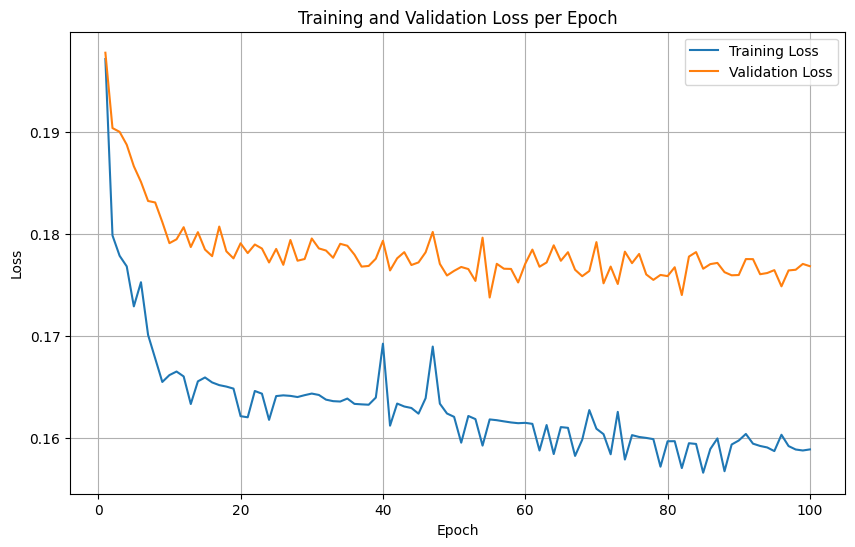

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(total_train_loss) + 1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, total_train_loss, label='Training Loss')
plt.plot(epochs, total_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim(0.3,0.4)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
bio_preds = []
for test in test_dataset:
  pred = model(test.x,test.edge_index,test.batch)
  bio_preds += pred

In [ ]:
predicts = []
for bio in bio_preds:
  if bio > 0.5:
    predicts.append(1)
  else:
    predicts.append(0)

In [ ]:
true_values = []
for t in test_dataset:
  true_values.append(t.y)

In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

cf = confusion_matrix(true_values,predicts)
f1 = f1_score(true_values,predicts)
accuracy = accuracy_score(true_values,predicts)

In [ ]:
print(accuracy)
print(cf)

0.8475991649269311
[[288  21]
 [ 52 118]]
